In [1]:
import os, sys
project_root = os.path.abspath("../..")
sys.path.insert(0, project_root)  # add repo entrypoint to python path
from typing import Annotated, List
from typing_extensions import TypedDict
from IPython.display import Image, display
import src.configs.config as cfg
from pathlib import Path
from pydantic import BaseModel, Field
from typing import Literal
from pydantic.types import SecretStr

# LangGraph and LangChain imports
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import StructuredTool, tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from src.utils.agent_utils import create_agent, get_llm
from src.tools.local_python_executor import local_python_executor, BASE_BUILTIN_MODULES
from src.utils.prompts import SYSTEM_PROMPT_DATA_ANALYST, SQLITE_PROMPT

In [2]:
# Initialize LLM
LLM = get_llm(
    llm_provider=cfg.LLM_PROVIDER,
    model_name=cfg.MODEL_NAME,
    api_key=cfg.OPENAI_API_KEY,
    temperature=0.5
)

# Allowed module imports for python executor
CUSTOM_MODULES = ['sqlalchemy', 'sqlite3', "matplotlib", 'dotenv', 'os', 'sys', 'pandas']
AUTHORIZED_IMPORTS = list(set(BASE_BUILTIN_MODULES) | set(CUSTOM_MODULES))

In [3]:
# @tool("python_tool", description="Execute Python code. Inputs: code (str).")
def python_tool(code: str):
    """Execute Python code safely with restricted imports.

    Args:
        code (str): The code to execute.

    Returns:
        The result of the execution.
    """
    try:
        return local_python_executor(code, AUTHORIZED_IMPORTS)
    except Exception as e:
        return {
            "error": str(e),
            "recovery_plan": (
                "Inspect error → Verify assumptions → Take countermeasures → Retry"
                )
            }
    
# Initialize in-memory checkpointing
checkpointer = InMemorySaver()  

# Create Data Analyst agent
data_analyst_agent = create_agent(
    llm=LLM,
    tools=[python_tool],
    system_prompt= SYSTEM_PROMPT_DATA_ANALYST+SQLITE_PROMPT,
    checkpointer=checkpointer,
)

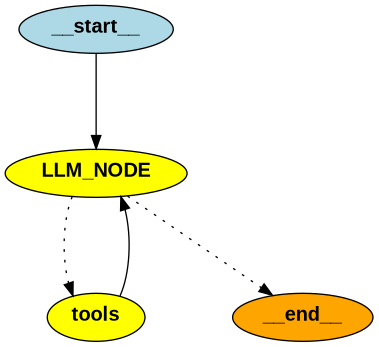

In [4]:
display(Image(data_analyst_agent.get_graph().draw_png()))

In [5]:
from src.agents.data_analyst import data_analyst_node
from src.agents.rag import rag_node
from src.agents.conversation import conversation_node
from src.agents.supervisor import supervisor_node

# Building the supervisor agent
# Graph initializing
builder = StateGraph(MessagesState) 

# Add nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("data_analyst", data_analyst_node)
builder.add_node("conversation", conversation_node)
builder.add_node("rag", rag_node)

# Add edges
builder.add_edge(START, "supervisor")

#Compile
checkpointer = InMemorySaver()
supervisor_agent = builder.compile(checkpointer=checkpointer)

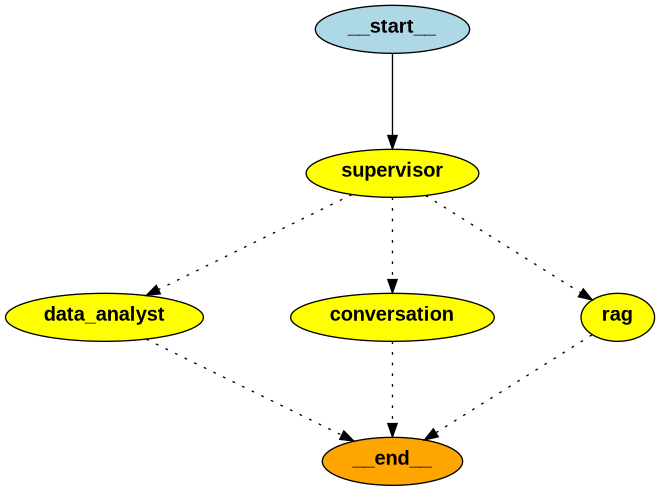

In [6]:
display(Image(supervisor_agent.get_graph().draw_png()))

In [ ]:
from sqlalchemy import create_engine, inspect, text

db_user = os.getenv('POSTGRES_USER')
db_password = os.getenv('POSTGRES_PASSWORD')
db_host = os.getenv('POSTGRES_HOST')
db_port = os.getenv('POSTGRES_PORT')
db_name = os.getenv('POSTGRES_DB')

# Create connection string and engine
connection_string = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection_string)

# Use inspector to explore schema
inspector = inspect(engine)

In [14]:
query = text("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_name = 'financials';
        """)

with engine.connect() as conn:
    result = conn.execute(query)
    schemas = [row[0] for row in result]

schemas

['company',
 'fiscal_year',
 'revenue',
 'net_income',
 'total_assets',
 'total_equity']

In [15]:
query = text("SELECT datname FROM pg_database WHERE datistemplate = false;")
with engine.connect() as conn:
    result = conn.execute(query)
    databases = [row[0] for row in result]
print("Databases:", databases)

Databases: ['postgres']


In [16]:
inspector.get_table_names(schema=db_schema_name)

['financials']

In [17]:
inspector.get_columns("financials", schema=db_schema_name)

[{'name': 'company',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None},
 {'name': 'fiscal_year',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None},
 {'name': 'revenue',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None},
 {'name': 'net_income',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None},
 {'name': 'total_assets',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None},
 {'name': 'total_equity',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None}]

In [18]:
schema_tables = {}

for schema in inspector.get_schema_names():
    # Skip system schemas if you want
    if schema in ("pg_catalog", "information_schema"):
        continue

    tables = inspector.get_table_names(schema=schema)
    if tables:
        schema_tables[schema] = tables

print(schema_tables)

{'schema_1': ['financials']}


In [ ]:
from sqlalchemy import create_engine, inspect
from dotenv import load_dotenv
import os

load_dotenv()

engine = create_engine(
    f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}"
    f"@{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/{os.getenv('POSTGRES_DB')}"
)

inspector = inspect(engine)

schemas = inspector.get_schema_names()
tables_by_schema = {
    schema: inspector.get_table_names(schema=schema)
    for schema in schemas
}

schemas, tables_by_schema

(['information_schema', 'schema_1'],
 {'information_schema': ['sql_features',
   'sql_implementation_info',
   'sql_parts',
   'sql_sizing'],
  'schema_1': ['financials']})